In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn')

# Constants
DATA_DIR = 'Data'
CHUNK_SIZE = 10000  # For processing large files

c:\Users\priya\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\priya\AppData\Local\Temp\ipykernel_18756\2645066766.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def load_json_chunk(file_path, chunk_size=CHUNK_SIZE):
    """Load JSON file in chunks to handle large files."""
    data = []
    with open(file_path, 'r') as f:
        try:
            json_data = json.load(f)
            # Extract deposits array
            deposits = json_data.get('deposits', [])
            for deposit in deposits:
                data.append({
                    'wallet_address': deposit['account']['id'],
                    'amount': float(deposit['amount']),
                    'amountUSD': float(deposit['amountUSD']),
                    'asset_symbol': deposit['asset']['symbol'],
                    'asset_id': deposit['asset']['id'],
                    'hash': deposit['hash'],
                    'timestamp': pd.to_datetime(int(deposit['timestamp']), unit='s')
                })
                if len(data) >= chunk_size:
                    yield pd.DataFrame(data)
                    data = []
            if data:
                yield pd.DataFrame(data)
        except json.JSONDecodeError as e:
            print(f"Error reading {file_path}: {e}")

# Load and process all JSON files
all_data = []
DATA_DIR = "C:\\Users\\priya\\Desktop\\PROJECTS\\Zeru Finance\\Compound-V2-wallet\\Data"
json_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.json')]

for json_file in json_files:
    file_path = os.path.join(DATA_DIR, json_file)
    print(f"Processing {json_file}...")
    for chunk in load_json_chunk(file_path):
        all_data.append(chunk)

# Combine all chunks
transactions_df = pd.concat(all_data, ignore_index=True)

# Display basic info
print(f"\nTotal transactions: {len(transactions_df)}")
print(f"Unique wallets: {transactions_df['wallet_address'].nunique()}")
print("\nFirst few transactions:")
transactions_df.head()

Processing compoundV2_transactions_ethereum_chunk_0.json...
Processing compoundV2_transactions_ethereum_chunk_1.json...
Processing compoundV2_transactions_ethereum_chunk_2.json...

Total transactions: 30000
Unique wallets: 8202

First few transactions:


,wallet_address,amount,amountUSD,asset_symbol,asset_id,hash,timestamp
0,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.000000e+16,1.78010,ETH,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,2019-05-07 01:41:22
1,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,8.000000e+16,14.24080,ETH,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,2019-05-07 01:45:11
2,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,4.582921e+21,1562.32014,BAT,0x0d8775f648430679a709e98d2b0cb6250d2887ef,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,2019-05-07 02:12:05
3,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,4.013963e+21,4013.96294,DAI,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,2019-05-07 02:12:05
4,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,9.990000e+18,1775.47275,ETH,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,2019-05-07 02:41:52


In [3]:
# Basic statistics
print("Transaction Amount Statistics (USD):")
print(transactions_df['amountUSD'].describe())

Transaction Amount Statistics (USD):
count    3.000000e+04
mean     9.049211e+03
std      7.047671e+04
min      0.000000e+00
25%      2.045599e+01
50%      2.354201e+02
75%      2.000376e+03
max      4.711189e+06
Name: amountUSD, dtype: float64


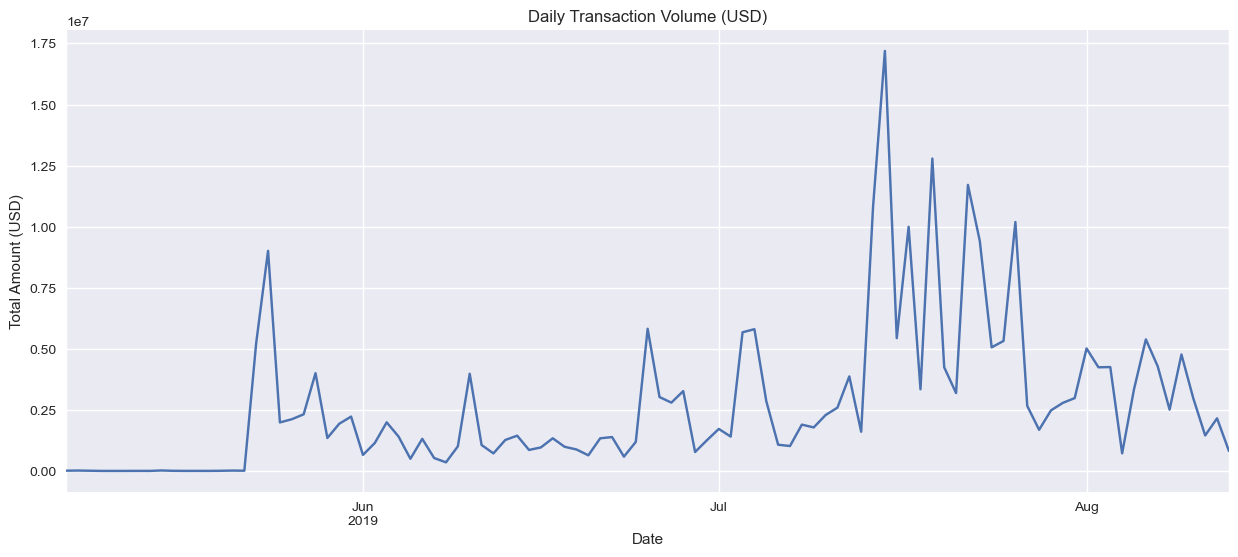

In [4]:
# Transaction volume over time
plt.figure(figsize=(15, 6))
daily_volume = transactions_df.set_index('timestamp')['amountUSD'].resample('D').sum()
daily_volume.plot()
plt.title('Daily Transaction Volume (USD)')
plt.xlabel('Date')
plt.ylabel('Total Amount (USD)')
plt.grid(True)
plt.show()

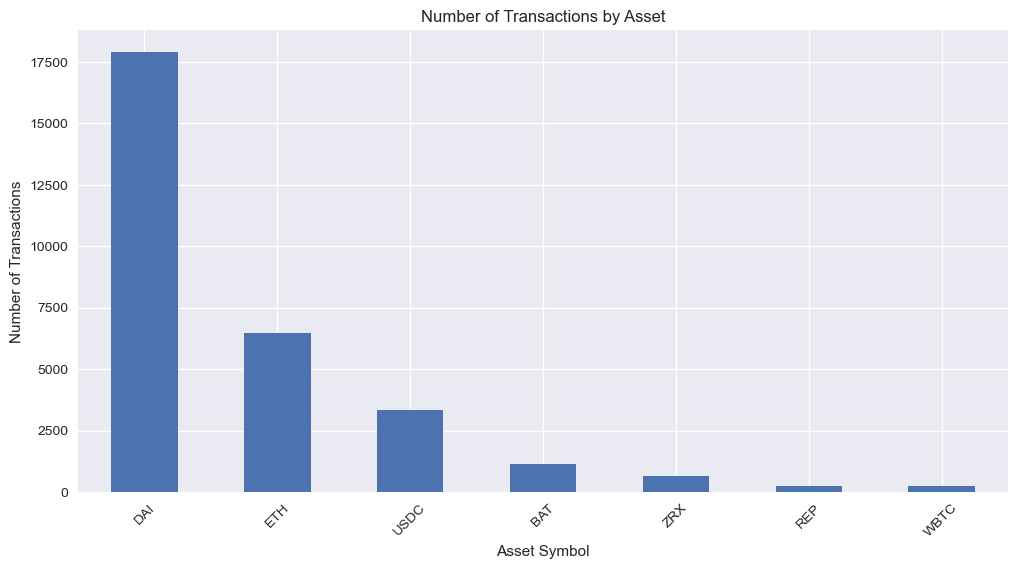

In [5]:
# Asset distribution
plt.figure(figsize=(12, 6))
asset_counts = transactions_df['asset_symbol'].value_counts()
asset_counts.plot(kind='bar')
plt.title('Number of Transactions by Asset')
plt.xlabel('Asset Symbol')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

c:\Users\priya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


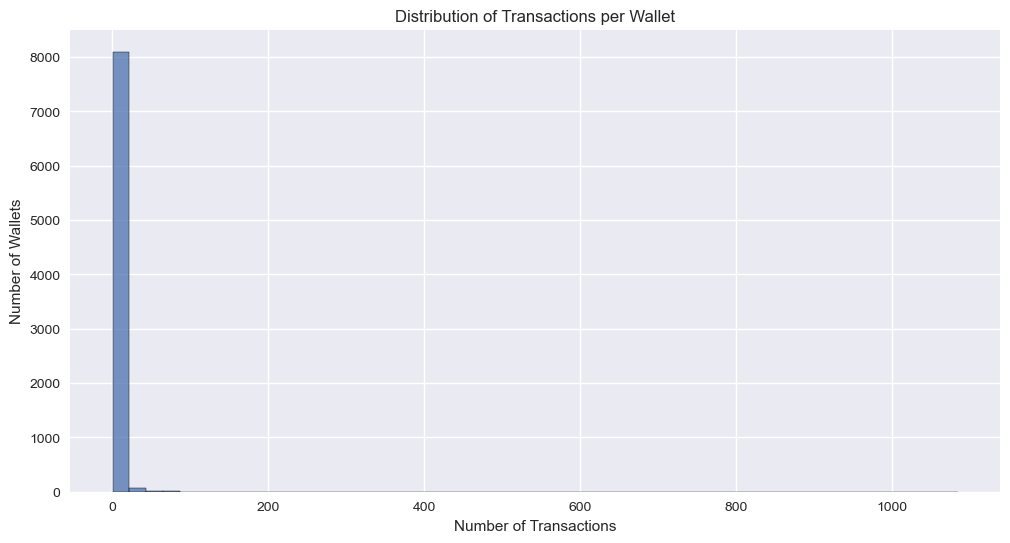

In [6]:
plt.figure(figsize=(12, 6))
wallet_activity = transactions_df['wallet_address'].value_counts()
sns.histplot(wallet_activity, bins=50)
plt.title('Distribution of Transactions per Wallet')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Wallets')
plt.show()

In [7]:
# Top 10 most active wallets
print("\nTop 10 Most Active Wallets:")
top_wallets = wallet_activity.head(10)
print(top_wallets)




Top 10 Most Active Wallets:
wallet_address
0x37acfef331e6063c8507c2a69c97b4f78c770a5a    1084
0x3eab4037a2e7f4d4d0946c091fe135838221f2b6     354
0xaeebe2d33fbdf50684161d1c1ed29a42ac915841     303
0x07326cbe4792e8e3c1f61c66fefee8253eb2db0c     204
0xbed4e3cd89918563a9ce4b04cf5379daf566bd53     145
0x0e0ec712b3912b5601216455a158cf18152cb62a     140
0xa24f2e6dcbd2da9a220958401dab74b365bd34e1     132
0x6168bb05ccb4aaded0169602bbb6e3cae12902c5     118
0x9d4da31a6f741c53a8f098bce221ecdd4a9cf6be     108
0xbabe31056c0fe1b704d811b2405f6e9f5ae5e59d     107
Name: count, dtype: int64


In [8]:
# Feature engineering at the wallet level
wallet_group = transactions_df.groupby('wallet_address')

wallet_features = pd.DataFrame({
    'total_transactions': wallet_group.size(),
    'total_amount_usd': wallet_group['amountUSD'].sum(),
    'avg_amount_usd': wallet_group['amountUSD'].mean(),
    'std_amount_usd': wallet_group['amountUSD'].std().fillna(0),
    'wallet_age_days': (wallet_group['timestamp'].max() - wallet_group['timestamp'].min()).dt.days + 1,
    'first_txn': wallet_group['timestamp'].min(),
    'last_txn': wallet_group['timestamp'].max(),
    'asset_diversity': wallet_group['asset_symbol'].nunique(),
})

# Transaction frequency (per day)
wallet_features['txn_per_day'] = wallet_features['total_transactions'] / wallet_features['wallet_age_days']

# Reset index to have wallet_address as a column
wallet_features = wallet_features.reset_index()

# Show feature statistics
print(wallet_features.describe())
wallet_features.head()

       total_transactions  total_amount_usd  avg_amount_usd  std_amount_usd  \
count         8202.000000      8.202000e+03    8.202000e+03    8.202000e+03   
mean             3.657644      3.309880e+04    5.612916e+03    2.846052e+03   
min              1.000000      0.000000e+00    0.000000e+00    0.000000e+00   
25%              1.000000      2.006928e+01    1.495414e+01    0.000000e+00   
50%              2.000000      2.149940e+02    1.063513e+02    2.754705e+00   
75%              3.000000      2.742523e+03    1.000395e+03    2.634925e+02   
max           1084.000000      3.968348e+07    4.711189e+06    1.334265e+06   
std             14.597125      5.604948e+05    6.679775e+04    2.987486e+04   

       wallet_age_days                      first_txn  \
count      8202.000000                           8202   
mean         10.097781  2019-07-10 05:58:17.292002048   
min           1.000000            2019-05-07 01:41:22   
25%           1.000000  2019-06-16 14:17:01.249999872   
50%

,wallet_address,total_transactions,total_amount_usd,avg_amount_usd,std_amount_usd,wallet_age_days,first_txn,last_txn,asset_diversity,txn_per_day
0,0x000000aaee6a496aaf7b7452518781786313400f,76,770814.615710,10142.297575,5740.490392,30,2019-07-02 10:53:55,2019-07-31 18:20:12,3,2.533333
1,0x00000a6bbb35ea3f6f8dbc94801738f490c30a8d,2,6.063779,3.031889,2.865407,3,2019-06-03 23:56:55,2019-06-06 20:25:14,1,0.666667
2,0x0006e4548aed4502ec8c844567840ce6ef1013f5,25,236378.577102,9455.143084,8744.263019,73,2019-05-15 11:32:11,2019-07-26 16:45:57,4,0.342466
3,0x0007808d13026d3245351759abc4f90a7bdd50de,2,14.972313,7.486156,3.529008,1,2019-08-02 05:16:52,2019-08-02 05:54:27,1,2.000000
4,0x000be263b3ceb55d22ed9b40d7619f62c4862c80,19,84697.515172,4457.763956,2520.430642,72,2019-05-27 02:41:05,2019-08-06 15:52:06,3,0.263889


In [9]:
# Normalize features
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Select features for clustering (exclude wallet_address, first_txn, last_txn)
feature_cols = [
    'total_transactions', 'total_amount_usd', 'avg_amount_usd',
    'std_amount_usd', 'wallet_age_days', 'asset_diversity', 'txn_per_day'
]

scaler = MinMaxScaler()
wallet_features_norm = pd.DataFrame(
    scaler.fit_transform(wallet_features[feature_cols]),
    columns=feature_cols,
    index=wallet_features.index
)

# Assign weights to each feature (adjust as needed)
weights = {
    'total_transactions': 0.3,        # Transaction consistency
    'std_amount_usd': 0.25,           # Risk management (lower std = more stable)
    'asset_diversity': 0.2,           # Protocol engagement
    'total_amount_usd': 0.15,         # Financial stability
    'wallet_age_days': 0.1            # Time-based factors
}

# Calculate weighted score
wallet_features['weighted_score'] = (
    weights['total_transactions'] * wallet_features_norm['total_transactions'] +
    weights['std_amount_usd'] * (1 - wallet_features_norm['std_amount_usd']) +  # invert std: lower is better
    weights['asset_diversity'] * wallet_features_norm['asset_diversity'] +
    weights['total_amount_usd'] * wallet_features_norm['total_amount_usd'] +
    weights['wallet_age_days'] * wallet_features_norm['wallet_age_days']
)

# Scale to 0-100
wallet_features['weighted_score'] = (wallet_features['weighted_score'] - wallet_features['weighted_score'].min()) / \
                                    (wallet_features['weighted_score'].max() - wallet_features['weighted_score'].min()) * 100

# Show top and bottom scoring wallets
print(wallet_features[['wallet_address', 'weighted_score']].sort_values('weighted_score', ascending=False).head())
print(wallet_features[['wallet_address', 'weighted_score']].sort_values('weighted_score', ascending=True).head())

                                  wallet_address  weighted_score
1798  0x37acfef331e6063c8507c2a69c97b4f78c770a5a      100.000000
3141  0x6168bb05ccb4aaded0169602bbb6e3cae12902c5       71.856174
2160  0x42b9df65b219b3dd36ff330a4dd8f327a6ada990       70.814515
7155  0xdf0635793e91d4f8e7426dbd9ed08471186f428d       69.771704
5172  0xa17f75c6d52951699350f308d1220e2dca7b4cda       69.494239
                                  wallet_address  weighted_score
2472  0x4becca336d9d7ab7aabddabc7985b26d683f15ea        0.000000
1621  0x320bb16ad49c27825e619a1ce658aeb4bcd68af0        1.135789
5014  0x9d11b1e1445b017902e561ceb201f009b3d53a42       12.282186
6212  0xc1852f917835a9f2f97112672bc5c8afd1f21dc3       12.355346
5298  0xa592cb9bde3df473e762545d54f6b89b36afde4c       19.713165


c:\Users\priya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


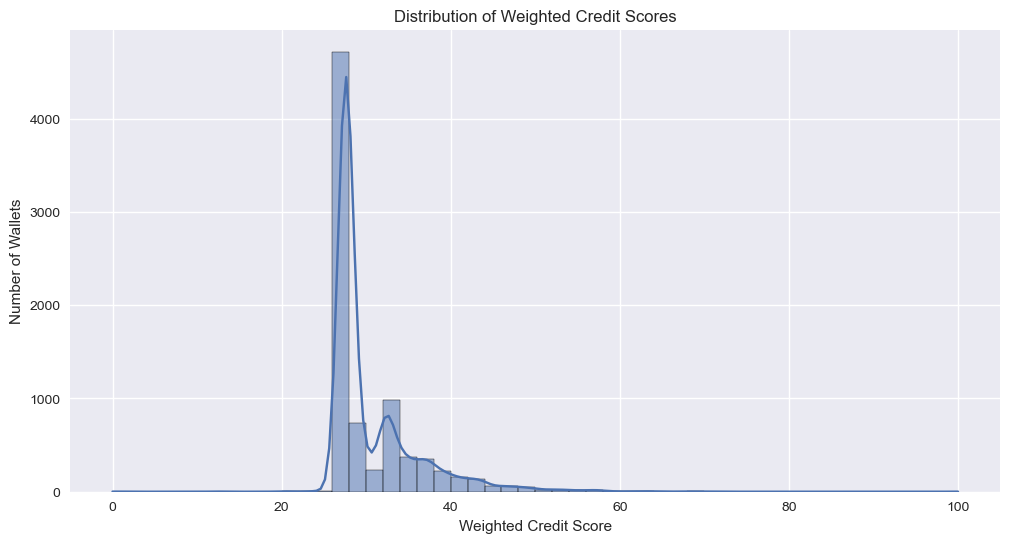

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(wallet_features['weighted_score'], bins=50, kde=True)
plt.title('Distribution of Weighted Credit Scores')
plt.xlabel('Weighted Credit Score')
plt.ylabel('Number of Wallets')
plt.show()

In [11]:
def score_band_label(score):
       if score < 20:
           return "Risky"
       elif score < 40:
           return "Low"
       elif score < 60:
           return "Good"
       elif score < 80:
           return "Very Good"
       else:
           return "Excellent"

wallet_features['score_band'] = wallet_features['weighted_score'].apply(score_band_label)
wallet_features['weighted_score'] = (wallet_features['weighted_score'] - wallet_features['weighted_score'].min()) / \
                                       (wallet_features['weighted_score'].max() - wallet_features['weighted_score'].min()) * 100
print(wallet_features[['wallet_address', 'weighted_score', 'score_band']].head())

                               wallet_address  weighted_score score_band
0  0x000000aaee6a496aaf7b7452518781786313400f       44.349647       Good
1  0x00000a6bbb35ea3f6f8dbc94801738f490c30a8d       27.860524        Low
2  0x0006e4548aed4502ec8c844567840ce6ef1013f5       53.130849       Good
3  0x0007808d13026d3245351759abc4f90a7bdd50de       27.560091        Low
4  0x000be263b3ceb55d22ed9b40d7619f62c4862c80       48.174750       Good


In [12]:
wallet_features.to_csv('wallet_features_new.csv', index=False)
print("All wallet features saved to wallet_features_new.csv")


top_weighted_wallets = wallet_features.sort_values('weighted_score', ascending=False)
top_weighted_wallets[['wallet_address', 'weighted_score']].to_csv('weighted_wallet_scores_new.csv', index=False)
print("All wallet credit scores saved to weighted_wallet_scores_new.csv")

All wallet features saved to wallet_features_new.csv
All wallet credit scores saved to weighted_wallet_scores_new.csv
